# Exercise 1: Quadrotor Flight with Deep Learning
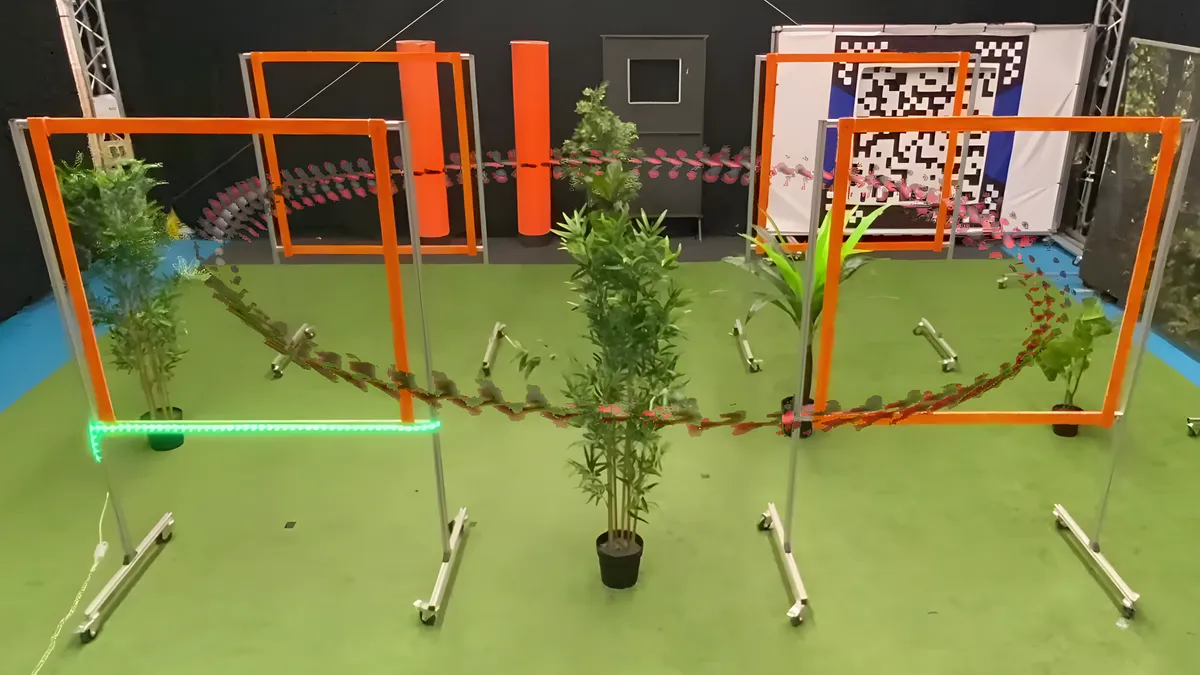
---
## Table of Contents
1. [Introduction](#introduction)
2. [Setup and Configuration](#setup-and-configuration)
3. [Data Preparation](#data-preparation)
   - [Dataset](#dataset)
   - [Visualization of Dataset](#visualization-of-dataset)
   - [Data Loading](#data-loading)
4. [Model Architecture](#model-architecture)
5. [Training the Model](#training-the-model)
   - [Loss Function and Optimizer](#loss-function-and-optimizer)
   - [Training Loop](#training-loop)
   - [Saving and Loading Model ](#saving-and-loading-model)
6. [Closed-Loop Model Evaluation](#closed-loop-model-evaluation)

## Introduction
Welcome to this exercise, where you will build and train a neural network using PyTorch to control a quadrotor drone. Throughout this process, you will explore the fundamentals of a deep learning pipeline, including data preparation, model architecture, training, and validation. 

Your objective is to train a model that can take in the state information of a quadrotor drone—such as its position, velocity, attitude, and angular velocity—and output the control signals needed (e.g., motor thrust) to guide the drone to the origin (X = Y = Z = 0) as quickly and efficiently as possible (balancing the trade-off between minimizing time and energy consumption).

To assist you, we’ve already generated a dataset of time-optimal trajectories in a simulation. These trajectories were computed using [Model Predictive Control (MPC)](https://www.do-mpc.com/en/latest/theory_mpc.html) in a simulated environment. Calculating such time-optimal trajectories is computationally intensive, but if we can approximate them using a neural network, we can make real-time control feasible even on platforms with limited computational resources, such as small drones. Let’s get started and explore how we can achieve this!

## Setup and Configuration
---
Machine learning programs consist of many components—datasets, dataloaders, models, and optimizers—each requiring numerous parameters known as hyperparameters for optimal performance. Instead of hardcoding these parameters directly into your code, it is considered best practice to use external configuration files. This approach provides several advantages:

- **Flexibility**: Modify settings without altering the core code.
- **Error Reduction**: Reduce the risk of errors when adjusting parameters.
- **Consistency**: Ensure uniform settings across different experiments and runs.
- **Portability**: Easily transfer code between different environments, such as from a local machine to a cloud platform for large-scale training.

Common formats for configuration files include JSON, YAML, and INI. We recommend YAML for its simplicity and readability.

In this exercise, we will use YAML with the Python library `yaml` to manage hyperparameters. We have defined hyperparameters in the YAML files located at `ex_1/config/2d.yaml` and `ex_1/config/3d.yaml`, tailored for training with the 2D or 3D variant of the trajectory dataset, respectively. Here is an example configuration from `2d.yaml`:

```yaml
trajectory_dim: 2
dataset_file: /workspaces/AE4353-Y24/data/2D_QUAD_HOVER.npz

batchsize_train: 1024
batchsize_val: 4096
shuffle_train: True
shuffle_val: False
num_workers_train_loader: 0
num_workers_val_loader: 0

model_hidden_dims: 120
model_num_layers: 4

epochs: 2
validate_per_steps: 500
lr: 0.001
```

Please execute the below cell to load the hyperparameter configuration into Python.

In [11]:
import yaml


def load_config(config_path: str) -> dict:
    """
    Load hyperparameters from a YAML configuration file.

    Parameters:
        config_path (str): Path to the YAML configuration file.

    Returns:
        dict: A dictionary containing the hyperparameters.
    """
    # Open the YAML file, load its content, and return dictionary
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config


config = load_config("config/2d.yaml")

For more complex configurations in future exercises, we will introduce the Hydra framework, which offers advanced hyperparameter management. If you are curious, you can explore [Hydra](https://hydra.cc/) on your own before we cover it in upcoming sessions.

## Data Preparation
---
Proper data preparation is essential for building effective machine learning models. This section covers three crucial tasks:

1. **Dataset**: Defining and implementing how data is organized and accessed using PyTorch’s dataset classes.
2. **Visualization of Dataset**: Using tools like [Rerun](https://rerun.io/) to explore and understand the data through visualization.
3. **Data Loading**: Efficiently batching and loading data using PyTorch’s `DataLoader` to streamline the training process.

These steps ensure your data is ready for training and validation.

### Dataset
In PyTorch, datasets can be loaded using two types of dataset objects: map-style datasets (`torch.utils.data.Dataset`) and iterable-style datasets (`torch.utils.data.IterableDataset`).

- **Map-style datasets**: These use an index to access data samples. As a rule of thumb, these should be used if the entire dataset is available from the start. Therefore, this is the type we will use in this exercise.
- **Iterable-style datasets**: These are used for data that is generated or streamed in real-time, such as live sensor data.

To work with data in PyTorch, you often need to define a custom dataset class. For map-style datasets, this involves subclassing the abstract `torch.utils.data.Dataset` class and implementing two methods:

- **`__len__()`**: Returns the total number of data samples in the dataset.
- **`__getitem__(index)`**: Retrieves the data sample corresponding to the provided index.

A sample implementation is as follows:

- **`TrajectoryDataset` Class**: This class handles our trajectory dataset.
  - **`flatten=False`**: Each sample is a full trajectory with multiple timesteps.
  - **`flatten=True`**: Each sample represents a single timestep within a trajectory. This setup helps achieve a more i.i.d. (independent and identically distributed) dataset by shuffling the order of input as much as possible, which is beneficial during training. Therefore, we set `flatten=True` for training.

- **`prepare_dataset` Function**: This function loads the dataset stored in numpy format, using the first 80% of the trajectories as the training set and the remaining 20% as the validation set.

Please execute the following cell to utilize the dataset preparation features. This will load the `TrajectoryDataset` class and the `prepare_dataset` function.

In [12]:
from config.dataloader import TrajectoryDataset, prepare_dataset

Now let’s get the dataset ready for training! Run the cell below, and you will get two PyTorch datasets back: one for training (with flattened trajectories) and one for validation (with non-flattened trajectories).

In [13]:
train_set, val_set = prepare_dataset(config["dataset_file"], config["trajectory_dim"])

100000 >>> Total Trajectories
80000  >>> Training Set Trajectories
20000  >>> Validation Set Trajectories


>>> Loading Dataset:   0%|          | 0/9 [00:00<?, ?it/s]

>>> Assembling Dataset (2D):   0%|          | 0/80000 [00:00<?, ?it/s]

>>> Assembling Dataset (2D):   0%|          | 0/20000 [00:00<?, ?it/s]

### Visualization of Dataset
Visualization is a crucial tool in machine learning. As Geoffrey Hinton said, "Every time you visualize something, you learn something new."

The first step in solving a machine learning problem is to visualize the dataset. This helps you intuitively grasp the data's patterns and complexities before designing your solution. Throughout your pipeline, visualizing intermediate variables and errors is invaluable for debugging and identifying model limitations.

For this course, we will use [Rerun](https://rerun.io/) and [Matplotlib](https://matplotlib.org/) as our primary visualization tool. Rerun is a high-performance, cross-platform tool that supports various data types. It allows data streaming over a network and can run as a standalone program, in a web browser, or embedded in a Jupyter notebook. These features make Rerun ideal for visualizing data from remote training jobs on a local machine.

Run the cell below to see the first trajectory in the validation set. It will show the trajectory on a 2D plane, along with how other variables change over time. You can drag the timeline or press play to watch how these variables evolve.

In [ ]:
import rerun as rr
import rerun.blueprint as rrb


# Initialize rerun
rr.init("dataset")
rr.log(
    "/world/Bounding_Box",
    rr.Boxes2D(mins=[-10, -10], sizes=[20, 20]),
    timeless=True,
)
rr.log(
    "/world/Destination",
    rr.Points2D([0, 0], colors=[0, 255, 0]),
    timeless=True,
)

# Get the first trajectory and control inputs from the validation set
x_traj, u = val_set[0]

# Log trajectory variables and controls for each time step
for i, x in enumerate(x_traj):
    rr.set_time_sequence("traj_time", i)
    rr.log("X/vy", rr.Scalar(x[2]))  # Log vy, velocity in y
    rr.log("X/vz", rr.Scalar(x[3]))  # Log vz, velocity in z
    rr.log("X/theta", rr.Scalar(x[4]))  # Log theta, pitch angle
    rr.log("X/omega", rr.Scalar(x[5]))  # Log omega, angular velocity (pitch rate)
    rr.log("U/ul", rr.Scalar(u[i, 0]))  # Log ul, left motor command
    rr.log("U/ur", rr.Scalar(u[i, 1]))  # Log ur, right motor command
    rr.log("/world/pos", rr.Points2D([x[0], x[1]]))  # Log position in the world

# Create a blueprint for visualization
blueprint = rrb.Blueprint(
    rrb.Horizontal(
        rrb.Spatial2DView(
            origin="/world",
            time_ranges=[
                rrb.VisibleTimeRange(
                    "traj_time",
                    start=rrb.TimeRangeBoundary.infinite(),
                    end=rrb.TimeRangeBoundary.cursor_relative(seq=0),
                )
            ],
        ),
        rrb.Vertical(rrb.TimeSeriesView(origin="/X"), rrb.TimeSeriesView(origin="/U")),
    )
)

# Show the visualization in the notebook
rr.send_blueprint(blueprint)
rr.notebook_show()

Now let's take a look at some more trajectories in the training and validation sets.

In [ ]:
import random
import rerun as rr
from torch.utils.data import Subset


# Initialize rerun
rr.init("training set trajectories")
rr.log(
    "/world/Bounding_Box", rr.Boxes2D(mins=[-10, -10], sizes=[20, 20]), timeless=True
)
rr.log("/world/Destination", rr.Points2D([0, 0], colors=[0, 255, 0]), timeless=True)

# Create subsets of the validation and training sets
n = 100  # Number of trajectories to visualize
sub_val_set = Subset(val_set, random.sample(range(len(val_set)), n))
train_set.flatten = False  # Temporarily disable flattening for the train_set
sub_train_set = Subset(train_set, random.sample(range(len(train_set)), n))

# Visualize trajectories in the subsets
for dataset, dataset_name in zip(
    [sub_train_set, sub_val_set], ["training", "validation"]
):
    for i, (x_traj, u) in enumerate(dataset):
        rr.send_columns(
            f"/{dataset_name}/traj_{i}",
            times=[rr.TimeSequenceColumn("traj_time", range(len(x_traj)))],
            components=[
                rr.Points2D.indicator(),
                rr.components.Position2DBatch(x_traj[:, 0:2]).partition(
                    [1] * len(x_traj)
                ),
            ],
        )

# Create a blueprint for visualization
blueprint = rrb.Blueprint(
    rrb.Horizontal(
        rrb.Spatial2DView(
            origin="/validation",
            visual_bounds=rrb.VisualBounds2D(x_range=[-10, 10], y_range=[-10, 10]),
            time_ranges=[
                rrb.VisibleTimeRange(
                    "traj_time",
                    start=rrb.TimeRangeBoundary.infinite(),
                    end=rrb.TimeRangeBoundary.cursor_relative(seq=0),
                )
            ],
        ),
        rrb.Spatial2DView(
            origin="/training",
            visual_bounds=rrb.VisualBounds2D(x_range=[-10, 10], y_range=[-10, 10]),
            time_ranges=[
                rrb.VisibleTimeRange(
                    "traj_time",
                    start=rrb.TimeRangeBoundary.infinite(),
                    end=rrb.TimeRangeBoundary.cursor_relative(seq=0),
                )
            ],
        ),
    )
)

# Show the visualization in the notebook
rr.send_blueprint(blueprint)
rr.notebook_show()

# Re-enable flattening for the train_set
train_set.flatten = True

### Data Loading
In PyTorch, the `DataLoader` is a utility that handles the loading and batching of data from a dataset during training. When working with a map-style dataset, the `DataLoader` is responsible for efficiently fetching and organizing data into batches for the training process.

Key arguments that enhance the functionality of the `DataLoader` include:

- **`batch_size`**: This argument specifies the number of samples per batch. For example, if `batch_size=32`, the `DataLoader` will group 32 samples together and return them as a single batch during each iteration.

- **`shuffle`**: When set to `True`, the `DataLoader` shuffles the data at the beginning of each epoch. This helps prevent the model from learning the order of the data, which improves generalization and reduces overfitting.

- **`num_workers`**: This argument defines the number of subprocesses to use for data loading. A higher value can speed up data loading by parallelizing the process. A value of 0 means data loading will occur in the main thread (i.e. no additional dataloader processes are launched). This is useful for debugging, as it avoids the complexity of dealing with concurrent processes. For small datasets, a value of 0 is often sufficient.

In practice, the `DataLoader` manages data fetching and batching efficiently, allowing the training loop to focus on processing the data rather than handling the complexities of data loading.


Execute the cell below to create training and validation set loaders.

In [ ]:
from torch.utils.data import DataLoader


# Create training set loader
train_loader = DataLoader(
    train_set,
    batch_size=config["batchsize_train"],
    shuffle=config["shuffle_train"],
    num_workers=config["num_workers_train_loader"],
)

# Create validation set loader
val_loader = DataLoader(
    val_set,
    batch_size=config["batchsize_val"],
    shuffle=config["shuffle_val"],
    num_workers=config["num_workers_val_loader"],
)

## Model Architecture
---
In PyTorch, neural networks are built using reusable modules such as layers, activation functions, and various operations. These modules can be combined and organized to create complex neural networks. To define a custom module, you subclass the `torch.nn.Module` class and implement the `forward` method. The `forward` method specifies how input data is transformed as it passes through the network.

The `nn.Module` class offers a flexible way to create both individual layers and entire networks. `nn.Module` objects can be nested within each other, facilitating the construction of sophisticated models. For example, you can create a custom layer by subclassing `nn.Module`, like `MyCustomLayer(nn.Module)`. This layer can then be used within another `nn.Module` object, such as `MyCustomNetwork(nn.Module)`. You instantiate the custom layer in `MyCustomNetwork`'s `__init__` method (e.g., `self.custom_layer = MyCustomLayer()`) and call it in the `forward` method (e.g., `self.custom_layer(...)`). This modular approach enhances code reuse and clarity.

PyTorch also provides the `nn.Sequential` container, which is a subclass of `nn.Module`. It allows for the sequential chaining of modules, where the output of one module’s forward method is automatically fed as the input to the next module. This makes it easy to build simple feedforward networks without manually defining the data flow between layers.

### nn.Parameter
In PyTorch, `nn.Parameter` is a special type of tensor designed to be used as a parameter within an `nn.Module`, such as the weights and biases in a `nn.Linear` layer.

When a tensor is wrapped in an `nn.Parameter` and assigned  **as an attribute** of an `nn.Module`, it is automatically included in the module’s list of parameters. This ensures it will be returned by the module’s `parameters()` method, which is essential for optimization. Regular tensors do not get automatically registered as parameters, even if they are used within an `nn.Module`.

By default, `nn.Parameter` tensors have `requires_grad=True`, meaning gradients will be computed for these tensors during backpropagation. In contrast, regular tensors default to `requires_grad=False`, unless explicitly set otherwise.

Parameters of `nn.Module` submodules that are registered as attributes are also recognized as parameters of the model. This makes it easy to track trainable parameters, as calling `model.parameters()` includes both the model's and its submodules' parameters. Additionally, model saving and loading utilities (`torch.save` and `torch.load`) handle the entire model's parameters, including those of its submodules.

### Model for This Exercise
In this exercise, we use a Multi-Layer Perceptron (MLP) network to map input to output. This network consists of 4 hidden layers of size 120, each connected by linear layers. To introduce non-linearity, we apply the Rectified Linear Unit (ReLU) activation function to the hidden units in each layer.

PyTorch provides implementations for commonly used layer types and activation functions, such as linear layers (`nn.Linear`), 2D convolutional layers (`nn.Conv2d`), ReLU (`nn.ReLU`), and Sigmoid (`nn.Sigmoid`).

Note that before the first linear layer, we normalize the input to a normal distribution with zero mean and unit variance ($
\mathcal{N}(0, 1)$). This normalization ensures that all input features are on a similar scale, which can accelerate convergence during training. It helps prevent certain features from dominating the learning process due to scale differences and maintains stable gradients throughout the network.



<strong style="color:red;">TODO: Complete the Normalize layer and end model definition</strong>

Execute the following cell to define the neural network model.

In [ ]:
from torch import nn


def compute_mean_std(
    test_set: Dataset, N: int = 10000
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the mean and standard deviation of the dataset.

    Parameters:
        test_set (nn.Dataset): The dataset to compute statistics on.
        N (int): The number of samples to use for computing mean and std.

    Returns:
        tuple[torch.Tensor, torch.Tensor]: The mean and standard deviation tensors.
    """
    X = torch.stack([test_set[i][0] for i in range(min(len(test_set), N))])
    return torch.mean(X, dim=0), torch.std(X, dim=0)


class Normalize(nn.Module):
    def __init__(self, mean: torch.Tensor, std: torch.Tensor) -> None:
        """
        Initializes the Normalize layer.

        Parameters:
            mean (torch.Tensor): Mean values for normalization.
            std (torch.Tensor): Standard deviation values for normalization.
        """
        # TODO: Implement the __init__ method
        pass
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Normalize the input tensor.

        Parameters:
            x (torch.Tensor): The input tensor to normalize.

        Returns:
            torch.Tensor: The normalized tensor.
        """
        # TODO: Implement the forward method
        pass




# TODO: Write the end model class and instantiate it as `model` 
model = ...


## Training the Model
---
Training a machine learning model involves optimizing its parameters to minimize some relationship between its predictions and the input data. This process requires defining a loss function that quantifies how well the model performs and choosing an optimizer to adjust the model’s parameters based on the computed gradients.

### Loss Function and Optimizer
To train a model effectively, we need a loss function that quantifies how well the model fits the data. In this exercise, we use the Mean Squared Error (MSE) loss, which measures the discrepancy between the model’s predicted control actions and the ground truth optimal actions.

Alongside the loss function, we require an optimizer to adjust the model's parameters. When instantiating the optimizer, we need to pass in the set of parameters to be learned. This allows the optimizer to track the gradients of those parameters and maintain statistics that can help the model converge more quickly and robustly. 

In our case, we adopt the widely-used Adam optimizer. It comes with several hyperparameters, with the learning rate being the most crucial. We will configure the learning rate while keeping the other hyperparameters at their default values.


Execute the cell below to set the loss function and optimizer.

In [ ]:
# Loss function
criterion = torch.nn.MSELoss()  # Define the Mean Squared Error loss function

# Optimizer
learning_rate = config["lr"]  # Get the learning rate from the config dictionary
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate
)  # Use the Adam optimizer to update the model parameters

### Training Loop
A typical training loop consists of an outer loop that iterates over epochs (where one epoch is a full pass through the entire training set) and an inner loop where the data loader iterates over batches of data within each epoch.

While it is not strictly necessary to set the model to training mode using `model.train()`, it is good practice to do so. This is because certain `nn.Module` components, such as [dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) and [batch normalization layers](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), behave differently depending on whether the model is in training or evaluation mode.

The main steps of the training loop are as follows:
- **`optimizer.zero_grad()`**: This step clears the gradients of all parameters. In PyTorch, gradients accumulate by default, so it’s essential to zero them out at the start of each iteration to prevent mixing gradients from different batches.
- **`outputs = model(input)`**: The model performs a forward pass with the input data, generating predictions based on the current state of its parameters.
- **`loss = criterion(outputs, targets)`**: The loss function (criterion) compares the model’s predictions to the true target values and computes the loss, a scalar that indicates how well the model’s predictions match the targets. This value is used to guide the model's learning.
- **`loss.backward()`**: This step calculates the gradients of the loss with respect to each model parameter using backpropagation. PyTorch’s autograd engine performs this computation, determining how to adjust each parameter to minimize the loss.
- **`optimizer.step()`**: The optimizer updates the model’s parameters based on the computed gradients. Using the Adam algorithm, the optimizer adjusts the parameters in the direction that reduces the loss, improving the model’s performance over time.


Ready to see our model in action? Run the cell below to start the training loop, which includes a validation step every 500 steps. During these validations, we’ll generate plots to highlight the model’s worst predictions and evaluate its performance at various loss percentiles. Additionally, the validation loss will be logged. Let’s dive in and get started with training!

In [ ]:
import matplotlib.pyplot as plt


# Number of worst predictions to plot
top_k = 5


def plot_predictions(
    model: nn.Module,
    val_set: Dataset,
    top_indices: torch.Tensor,
    step: int,
) -> None:
    """
    Plot the worst predictions based on validation loss.

    Parameters:
        model (nn.Module): Trained PyTorch model.
        val_set (Dataset): Validation dataset.
        top_indices (torch.Tensor): Indices of top-k worst predictions.
        step (int): Current training step.
    """
    fig, axs = plt.subplots(2, len(top_indices), figsize=(12, 6))

    for i, idx in enumerate(top_indices):
        # Fetch trajectory and ground truth values
        x_traj, u = val_set[idx]
        # Predict using the model
        u_pred = model(x_traj)

        # Plot ground truth and predicted values for both components of the output
        axs[0, i].plot(range(len(x_traj)), u[:, 0], label="l-gt")
        axs[0, i].plot(range(len(x_traj)), u_pred[:, 0], label="l-pred")
        axs[1, i].plot(range(len(x_traj)), u[:, 1], label="r-gt")
        axs[1, i].plot(range(len(x_traj)), u_pred[:, 1], label="r-pred")
        # Add text annotation for each subplot
        axs[0, i].text(
            0.5,
            0.5,
            f"traj {idx}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, i].transAxes,
        )
        # Add legend to the last plot for both components
        if i == len(top_indices) - 1:
            axs[0, i].legend()
            axs[1, i].legend()

    plt.suptitle(f"{top_k} Worst Predictions at Step={step}")
    plt.tight_layout()
    plt.show()


def plot_percentiles(
    model: nn.Module,
    val_set: Dataset,
    val_loss: torch.Tensor,
    percentiles: list[int],
) -> None:
    """
    Plot predictions at specified percentiles of the validation loss distribution.

    Parameters:
        model (nn.Module): Trained PyTorch model.
        val_set (Dataset): Validation dataset.
        val_loss (torch.Tensor): Computed validation loss for each sample.
        percentiles (list[int]): List of percentiles to plot.
    """
    # Sort losses to find indices for each percentile
    _, sorted_indices = torch.sort(val_loss)
    # Compute positions for each percentile in the sorted indices
    positions = [(p / 100.0) * (len(val_loss) - 1) for p in percentiles]
    fig, axs = plt.subplots(2, len(percentiles), figsize=(12, 6))

    # Iterate over each percentile and plot the corresponding predictions
    for i, (idx, percentile) in enumerate(zip(positions, percentiles)):
        idx = int(idx)
        # Retrieve trajectory and ground truth values
        x_traj, u = val_set[sorted_indices[idx]]
        # Predict using the model
        u_pred = model(x_traj)

        # Plot ground truth and predicted values for both components of the output
        axs[0, i].plot(range(len(x_traj)), u[:, 0], label="l-gt")
        axs[0, i].plot(range(len(x_traj)), u_pred[:, 0], label="l-pred")
        axs[1, i].plot(range(len(x_traj)), u[:, 1], label="r-gt")
        axs[1, i].plot(range(len(x_traj)), u_pred[:, 1], label="r-pred")
        # Add text annotation and title for each subplot
        axs[0, i].text(
            0.5,
            0.5,
            f"traj {sorted_indices[idx]}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=axs[0, i].transAxes,
        )
        axs[0, i].set_title(f"{percentile}th Percentile")
        # Add legend to the last plot for both components
        if i == len(positions) - 1:
            axs[0, i].legend()
            axs[1, i].legend()

    plt.tight_layout()
    plt.show()


# Define loss criterion for validation
val_criterion = torch.nn.MSELoss(reduction="none")


def validate(
    model: nn.Module,
    val_loader: DataLoader,
    val_set: Dataset,
    step: int,
) -> float:
    """
    Validate the model on the validation set and plot results.

    Parameters:
        model (nn.Module): Trained PyTorch model.
        val_loader (DataLoader): Validation data loader.
        val_set (Dataset): Validation dataset.
        step (int): Current training step.

    Returns:
        float: The average validation loss.
    """
    model.eval()  # Set model to evaluation mode
    val_loss = []  # Validation loss values

    with torch.no_grad():  # Disable gradient calculation for validation
        total_loss = 0

        # Iterate over the validation dataset
        for val_inputs, val_targets in val_loader:
            # Perform forward pass and compute predictions
            val_outputs = model(val_inputs)
            # Compute the mean squared error loss without reduction, then average over dimensions
            loss = val_criterion(val_outputs, val_targets).mean(dim=(1, 2))
            val_loss.append(loss)
            total_loss += loss.mean().item()  # Accumulate the total loss

        # Compute the average validation loss
        total_loss /= len(val_loader)
        val_loss = torch.concat(val_loss)

        # Plot the worst predictions
        _, top_indices = torch.topk(val_loss, top_k)
        plot_predictions(model, val_set, top_indices, step)

        # Plot predictions at different percentiles
        percentiles = [25, 50, 75, 95, 99]
        plot_percentiles(model, val_set, val_loss, percentiles)

    model.train()  # Set model back to training mode
    return total_loss


def reset_weights(m: nn.Module) -> None:
    """
    Reset weights of the model.

    Parameters:
        m (nn.Module): Model layer to reset.
    """
    if isinstance(m, torch.nn.Linear):
        m.reset_parameters()

<strong style="color:red;">TODO: Complete the training loop. And tune the learning rate paramater in the YAML file to achieve fast and effective learning.</strong>

You can expect a validation error around 0.003 after 2 epochs of training.

In [ ]:
# Apply weight reset to the model
model.apply(reset_weights)

# Initialize rerun and show the training loop
rr.init("training loop")
rr.notebook_show()

# Training and validation loop
validate_per_steps = config["validate_per_steps"]
for epoch in tqdm(range(config["epochs"]), desc="Epochs"):
    # TODO: Implement the training loop
        step = 0
        ...
    

        # TODO: Log training loss to rerun
        # rr.log("loss/train", rr.Scalar(<a scalar value>))

        # TODO: Validate the model at defined intervals
        if step % validate_per_steps == 0 and step > 0:
            total_loss = validate(model, val_loader, val_set, step)
            rr.log("loss/val", rr.Scalar(total_loss))


### Saving and Loading the Model
After training the model, it’s important to save its weights so you can reuse the model later. The best practice is to save only the model parameters using `model.state_dict()`, rather than saving the entire model. This approach avoids the security risks associated with serializing the Python code that defines the model architecture, which could potentially expose the system to malicious code when reloaded.

To load a saved model, first instantiate a new model object and then use the `load_state_dict()` method to load the saved parameters into this model object.


Run the cell below to save the trained model and then reload it.

In [ ]:
# Save model
torch.save(model.state_dict(), "model_trained.pt")

# Load model
model.load_state_dict(torch.load("model_trained.pt", weights_only=True))

## Closed-Loop Model Evaluation
---
After training the model, it is essential to evaluate its performance to ensure it operates as intended in closed-loop.

In this section, we will deploy the trained model in closed-loop simulation to evaluate its interaction with the system it is designed to control. Below, we have set up a controller based on the trained model, defined the system dynamics of a 2D quadrotor drone, and prepared a simulation environment to evaluate the trained model.

<strong style="color:red;">TODO: Implement the neural-network-based controller. Pay attention to how the model should be called differently now versus training time.</strong>

Then run the cell to establish the system dynamics, and set up the simulation environment for evaluating the model.

In [ ]:
# Define controller
def controller(x: np.ndarray) -> np.ndarray:
    """
    Compute the control output using the trained model.

    Parameters:
        x (np.ndarray): The state vector.

    Returns:
        np.ndarray: Control output as a numpy array.
    """
    # TODO: Implemenet the controller function
    pass


# Define system dynamics
def f(x: np.ndarray, u: np.ndarray) -> np.ndarray:
    """
    Compute the dynamics of the system given the state and control input.

    Parameters:
        x (np.ndarray): The current state vector [y, z, vy, vz, theta, omega].
        u (np.ndarray): The control input vector [ul, ur].

    Returns:
        np.ndarray: The derivatives of the state vector as a numpy array.
    """
    # Unpack state variables
    y, z, vy, vz, theta, omega = x

    # Unpack control variables
    ul, ur = u

    # Define parameters
    g = 9.81  # Gravity (m/s^2)
    m = 0.389  # Mass (kg)
    Ixx = 0.001242  # Moment of inertia (kg*m^2)
    L = 0.08  # Length (m)
    maxthrust = 2.35  # Maximum thrust (N)
    minthrust = 1.76  # Minimum thrust (N)
    M = maxthrust - minthrust  # Thrust range (N)
    F = 2 * minthrust  # Base thrust (N)
    beta = 0.5  # Drag coefficient (-)

    # Compute dynamics
    dy_dt = vy
    dz_dt = vz
    dv_ydt = -((ur + ul) / m * M + F / m) * np.sin(theta) - beta * vy
    dvz_dt = ((ur + ul) / m * M + F / m) * np.cos(theta) - g - beta * vz
    dtheta_dt = omega
    domega_dt = L / Ixx * M * (ur - ul)

    return np.array([dy_dt, dz_dt, dv_ydt, dvz_dt, dtheta_dt, domega_dt])


# Simulate the system dynamics over time
def simulate(
    y0: float, z0: float, vy0: float, vz0: float, theta0: float, omega0: float, T: float
) -> dict:
    """
    Simulate the system dynamics over time.

    Parameters:
        y0 (float): Initial y position.
        z0 (float): Initial z position.
        vy0 (float): Initial y velocity.
        vz0 (float): Initial z velocity.
        theta0 (float): Initial angle.
        omega0 (float): Initial angular velocity.
        T (float): Total simulation time.

    Returns:
        dict: A dictionary containing time series data for state variables and control inputs.
    """
    dt = 0.01
    t = np.linspace(0, T, int(T / dt))

    # Initialize states and control inputs
    x = np.array([y0, z0, vy0, vz0, theta0, omega0])
    X = [x]
    U = []

    # Simulation loop
    for _ in range(len(t) - 1):
        # Get control input
        u = controller(x)
        # Update state using dynamics function
        x = x + f(x, u) * dt
        # Store state and control input
        X.append(x)
        U.append(u)

    # Compute final control input
    u = controller(x)
    U.append(u)
    X = np.array(X)
    U = np.array(U)

    # Return simulation results
    return {
        "t": t,
        "y": X[:, 0],
        "z": X[:, 1],
        "vy": X[:, 2],
        "vz": X[:, 3],
        "theta": X[:, 4],
        "omega": X[:, 5],
        "ul": U[:, 0],
        "ur": U[:, 1],
    }

Now, run the cell below to evaluate the effectiveness of the trained model by simulating the quadrotor's trajectories controlled by the model. Try experimenting with different initial conditions (e.g. $y_0=5, z_0=5, v_{y_0}=10, v_{z_0}=5, \theta_0=2, \omega_0=2, T=5$) to see how well the quadrotor drone returns to the origin.

In [ ]:
# Simulate trajectory
traj = simulate(y0=5, z0=5, vy0=10, vz0=5, theta0=2, omega0=2, T=5)

# Initialize rerun
rr.init("test trajectory")
rr.log(
    "/world/Bounding Box", rr.Boxes2D(mins=[-10, -10], sizes=[20, 20]), timeless=True
)
rr.log("/world/Destination", rr.Points2D([0, 0], colors=[0, 255, 0]), timeless=True)

# Log trajectory data at each timestep
for i, x in enumerate(traj["t"]):
    rr.set_time_seconds("traj_time", x)
    rr.log("X/vy", rr.Scalar(traj["vy"][i]))
    rr.log("X/vz", rr.Scalar(-traj["vz"][i]))
    rr.log("X/theta", rr.Scalar(traj["theta"][i]))
    rr.log("X/omega", rr.Scalar(traj["omega"][i]))
    rr.log("U/ul", rr.Scalar(traj["ul"][i]))
    rr.log("U/ur", rr.Scalar(traj["ur"][i]))
    rr.log("/world/pos", rr.Points2D([traj["y"][i], -traj["z"][i]]))

# Create a blueprint for visualization
blueprint = rrb.Blueprint(
    rrb.Horizontal(
        rrb.Spatial2DView(
            origin="/world",
            time_ranges=[
                rrb.VisibleTimeRange(
                    "traj_time",
                    start=rrb.TimeRangeBoundary.infinite(),
                    end=rrb.TimeRangeBoundary.cursor_relative(seq=0),
                )
            ],
        ),
        rrb.Vertical(
            rrb.TimeSeriesView(origin="/X"),
            rrb.TimeSeriesView(origin="/U"),
        ),
    )
)

# Show the visualisation in the notebook
rr.send_blueprint(blueprint)
rr.notebook_show()

You have reached the end of Exercise 1, good job! We hope you enjoyed the learning journey and gained valuable insights. Keep experimenting, keep learning, and happy coding!